## Advanced Recurrent Neural Networks

$\text{RNN}$이 동적 시계열 모델에의 확장은 시계열 분석의 근본 개념을 확장하는 것에 의존한다. 우선 hidden states $\hat{h}_t$를 가진 평활화된 $\text{RNN}$을 고려한다. 이와 같은 $\text{RNN}$은 기본 $\text{RNN}$과 거의 동일하다. 그러나 network에 long memory를 제공하는 추가적인 scalar smoothing parameter $\alpha$를 가진다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

START = '1960-01-01'
TICKER = '^GSPC' # S&P500 Index

data = yf.download(
    TICKER,
    start = START,
    progress = False,
    interval = '1wk'
)

In [2]:
returns = data['Close'].pct_change(1).dropna()

In [3]:
import torch
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

### 1. $\alpha$-RNN

Smoothing Parameter가 고정된 일변량 $\alpha - \text{RNN}(p)$모형을 고려하자.

$$\begin{align*} 
\hat{y}_{t+1} &= W_y \hat{h}_t + b_y \\
\hat{h}_t &= \sigma(U_h \tilde{h}_{t-1} + W_h y_t + b_h) \\
\tilde{h}_t &= \alpha \hat{h}_{t-1} + (1 - \alpha) \tilde{h}_{t-1}
\end{align*}$$

각 sequence의 초기 조건은 $\hat{h}_{t - p + 1} = y_{t-p+1}$이다. 이 모델은 Hidden Layer의 $\hat{h}_{t-1}$을 지수 평활화된 Hidden states $\tilde{h}_{t-1}$로 대체함으로써 기본 $\text{RNN}$을 증강한다. 평활화의 효과는 $\alpha \neq 1$일 때 무한 메모리(기억)를 제공하는 것이다. 이 경우 $\text{RNN}$은 $\alpha = 1$인 특수한 경우라고 해석할 수 있다.

Parameter를 단순화하고 활성화함수가 없는 경우를 가정하면 이 모델을 보다 쉽게 해석할 수 있다. $b_y = b_h = 0$ 즉 각 노드마다 y-intercept는 없다고 가정하고, $U_h = W_h = \phi, W_y = 1$로 설정하면 다음을 얻을 수 있다.

$$\begin{align*} 
\hat{}y_{t+1} &= \hat{h}_t \\
&= \phi(\tilde{h}_{t-1} + y_t) \\
&= \phi (\alpha \hat{h}_{t-1} + (1-\alpha) \tilde{h}_{t-2} + y_t)
\end{align*}$$

일반성의 손실 없이 모델에서 $p = 2$의 time lag를 고려하면 $\hat{h}_{t-1} = \phi y_{t-1}$이다. 그러면 다음을 얻는다.

$$\hat{h}_t = \phi (\alpha \phi y_{t-1} + (1-\alpha)\tilde{h}_{t-2} + y_t)$$

모델은 더욱 간단한 형태로 표현할 수 있다. 

$$\hat{y}_{t+1} = \phi_1 y_t + \phi_2 y_{t-1} + \phi(1 - \alpha)\tilde{h}_{t-2}$$

여기서 자기회귀 가중치는 $\phi_1 := \phi$와 $\phi_2 := \alpha \phi^2$이다. 이제 $\text{AR}(2)$모델과 비교하면 $\alpha = 1$일 때 소멸하지만 $\tilde{h}_{t-2}$가 $y_0$에 의존하므로 모델에 무한 메모리를 제공하는 추가적 항이 있다는 것을 알 수 있다. 여기서 $y_0$는 sequence의 첫째 관측치가 아니라 전체 시계열의 첫째 관측치다. $\alpha - \text{RNN}$ Model은 $\alpha$를 Hyper Parameter로 취급해 훈련될 수 있다. $\alpha$를 고정시키는 선택은 명백히 정상성 시계열에 제한된다. 동적 버전의 지수 평활화를 사용해 모델을 비정상성 시계열로 확대할 수 있다.

In [4]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class AlphaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=0.5):
        super(AlphaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.alpha = alpha 
        self.phi = nn.Parameter(torch.Tensor(hidden_size, input_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.phi, a=0)

    def forward(self, input, hidden, smoothed_hidden):
        #h_hat = torch.sigmoid(F.linear(input, self.phi) + smoothed_hidden)
        h_hat = F.linear(input, self.phi) + smoothed_hidden
        smoothed_h = self.alpha * hidden + (1 - self.alpha) * smoothed_hidden

        return h_hat, smoothed_h
class AlphaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, alpha=0.5):
        super(AlphaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.alpha = alpha

        self.cells = nn.ModuleList(
            [AlphaRNNCell(input_size if i == 0 else hidden_size, hidden_size, alpha) for i in range(num_layers)]
        )

    def forward(self, input, hidden = None, smoothed_hidden = None):
        batch_size, seq_len, _ = input.size()

        if hidden is None:
            hidden = self.init_hidden(batch_size)
        if smoothed_hidden is None:
            smoothed_hidden = self.init_smoothed_hidden(batch_size)
        
        outputs = []
        for t in range(seq_len):
            x = input[:, t, :]  # Input at time t
            for i, cell in enumerate(self.cells):
                hidden[i], smoothed_hidden[i] = cell(x, hidden[i], smoothed_hidden[i])
                x = hidden[i] 
            outputs.append(x.unsqueeze(1))

        return torch.cat(outputs, dim=1), hidden, smoothed_hidden

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]
    
    def init_smoothed_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]

In [5]:
X = pd.concat(
    [returns.shift(1), returns.shift(2)], axis = 1
).dropna()
y = returns.iloc[2:].copy('deep')

X.columns = ['t-1','t-2']
y.name = 'returns'

In [6]:
X.head()

,t-1,t-2
Date,,
1960-01-22,-0.020377,-0.021612
1960-01-29,-0.018878,-0.020377
1960-02-05,0.002494,-0.018878
1960-02-12,-0.019371,0.002494
1960-02-19,0.011236,-0.019371


In [7]:
y.head()

Date
1960-01-22   -0.018878
1960-01-29    0.002494
1960-02-05   -0.019371
1960-02-12    0.011236
1960-02-19    0.002330
Name: returns, dtype: float64

In [8]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2019'], X.loc['2020':], y.loc[:'2019'], y.loc['2020':]

In [9]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 2 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.1
num_epochs = 1
batch_size = 2

# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [10]:
import torch.optim as optim

alpha_rnn = AlphaRNN(
    input_size = input_size, 
    hidden_size = hidden_size, 
    num_layers = num_layers, 
    alpha = 0.5
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    alpha_rnn.parameters(), 
    lr = learning_rate
)

In [11]:
dataset = torch.utils.data.TensorDataset(
    X_train_tensor, 
    y_train_tensor
)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size = batch_size, 
    shuffle = False
)

In [12]:
for epoch in range(num_epochs):
    alpha_rnn.train()
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        
        outputs, _ ,_ = alpha_rnn(batch_X)
        outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [1/1], Loss: 0.000497


In [13]:
alpha_rnn.eval()
with torch.no_grad():
    predicted_alpha_rnn, _, _ = alpha_rnn(X_test_tensor)
    predicted_alpha_rnn = predicted_alpha_rnn[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

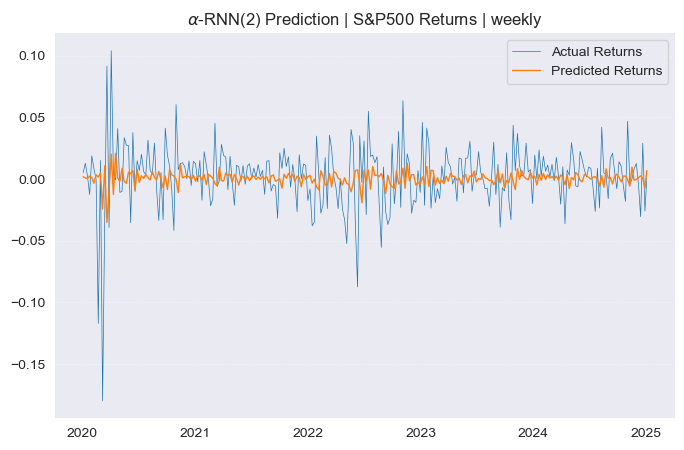

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_alpha_rnn, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'$\alpha$-RNN(2) Prediction | S&P500 Returns | weekly')
plt.show()

### 2. Dynamic $\alpha_t$ RNN

동적 지수 평활화는 평활화된 출력 $\tilde{y}_t$와 관측치 $y_t$의 시간 의존적 블록 결합이다.

$$\tilde{y}_{t+1} = \alpha_t y_t + (1 - \alpha_t)\tilde{y}_t$$

여기서 $\alpha_t \in [0,1]$은 시간에 따라 변화하는 평활화 계수를 의미하며, 이는 동일하게 1step ahead forecast 형태로 표현될 수 있다.

$$\tilde{y}_{t+1} = \tilde{y}_t + \alpha_t(y_t - \tilde{y}_t)$$

따라서 $\alpha_t \text{RNN}$은 Dynamic Forecast Error Correction Model의 일반화된 형태로 볼 수 있다. $\alpha_t = 0$인 경우 예측 오차는 무시되고, 평활화만 편재의 은닉 상태를 반복해 모델의 memory를 잃는 효과를 가진다. $\alpha_t = 1$인 경우에는 예측 오차가 현재의 은닉 상태 $\tilde{h}_t$를 완전히 대체한다.

또한 평활화는 time lag $s \geq 1$의 과거 관측 $y_{t-s}$에서 더 낮거나 같은 가중치 $\alpha_{t-s} \prod_{r=1}^s (1 - \alpha_{t-r+1})$을 사용한 lag 관측치들의 가중 합으로 볼 수 있다. 즉, 다음과 같다.

$$\tilde{y}_{t+1} = \alpha_t y_t + \sum_{s=1}^{t-1}\alpha_{t-s} \prod_{r=1}^s (1 - \alpha_{t-r+1})y_{t-s} + \prod_{r=0}^{t-1} \tilde{y}_1$$

여기서 마지막 항은 시간 의존적 상수이며 전형적으로 지수 평활화를 $\tilde{y}_1 = y_1$로 초기화한다. 임의의 $\alpha_{t-r+1} = 1$에 대해 예측 $\tilde{y}_{t+1}$은 모든 lag $\left\{ y_{t-s}\right\}_{s \geq r}$에 대해 어떠한 의존성도 갖지 않을 것이다. 모델은 단순히 $r$번째 lag 또는 이를넘어서는 관측을 망각한다. 평활화가 상수이고 $1 - \alpha$와 같은 특수한 경우의 앞의 표현은 다음과 같이 단순화된다.

$$\tilde{y}_{t+1} = \alpha \Phi (L)^{-1}y_t$$

또는 동일하게 $\tilde{y}_{t+1}$의 $\text{AR}(1)$ Process로 다음과 같이 표현될 수 있다.

$$\Phi(L) \tilde{y}_{t+1} = \alpha y_t$$

여기서 선형 연산자 $\Phi(z) := 1 + (\alpha = 1)_z$이며, $L$은 lag operator이다.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlphatRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AlphatRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.phi = nn.Parameter(torch.Tensor(hidden_size, input_size))

        self.alpha_fc = nn.Linear(input_size + hidden_size, 1) 

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.phi, a=0)
        nn.init.xavier_uniform_(self.alpha_fc.weight)

    def forward(self, input, hidden, smoothed_hidden):
        combined = torch.cat((input, hidden), dim=1)
        alpha_t = self.alpha_fc(combined)

        # Equation: h_hat_t = φ(smoothed_hidden + y_t)
        # h_hat = torch.sigmoid(F.linear(input, self.phi) + smoothed_hidden) # using activation function
        h_hat = F.linear(input, self.phi) + smoothed_hidden

        # Smoothed hidden state: α_t * h_{t-1} + (1 - α_t) * smoothed_hidden_{t-1}
        smoothed_h = alpha_t * hidden + (1 - alpha_t) * smoothed_hidden

        return h_hat, smoothed_h, alpha_t

class AlphatRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(AlphatRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList([AlphatRNNCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

    def forward(self, input, hidden=None, smoothed_hidden=None):
        batch_size, seq_len, _ = input.size()

        if hidden is None:
            hidden = self.init_hidden(batch_size)
        if smoothed_hidden is None:
            smoothed_hidden = self.init_smoothed_hidden(batch_size)

        outputs = []
        alphas = []  # Store α_t values for each time step

        for t in range(seq_len):
            x = input[:, t, :]  # Input at time t
            for i, cell in enumerate(self.cells):
                hidden[i], smoothed_hidden[i], alpha_t = cell(x, hidden[i], smoothed_hidden[i])
                x = hidden[i]  # Hidden state from current layer used as input to next layer

            outputs.append(x.unsqueeze(1))
            alphas.append(alpha_t.unsqueeze(1))  # Store α_t for each time step

        return torch.cat(outputs, dim=1), torch.cat(alphas, dim=1), hidden, smoothed_hidden

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]

    def init_smoothed_hidden(self, batch_size):
        return [torch.zeros(batch_size, self.hidden_size, device=self.cells[0].phi.device) for _ in range(self.num_layers)]

In [16]:
import torch.optim as optim

alpha_t_rnn = AlphatRNN(
    input_size = input_size, 
    hidden_size = hidden_size, 
    num_layers = num_layers
)

criterion = nn.MSELoss()
optimizer = optim.Adam(
    alpha_t_rnn.parameters(), 
    lr = learning_rate
)

In [17]:
num_epochs = 1
for epoch in range(num_epochs):
    alpha_t_rnn.train()
    optimizer.zero_grad()

    outputs, alphas, hidden, smoothed_hidden = alpha_t_rnn(X_train_tensor)

    outputs = torch.mean(outputs[:, -1, :], dim = 1, keepdim = True)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.000948


In [18]:
alpha_t_rnn.eval()
with torch.no_grad():
    predicted_alpha_t_rnn, alphas, _, _ = alpha_t_rnn(X_test_tensor)
    predicted_alpha_t_rnn = predicted_alpha_t_rnn[:, -1, :].mean(dim=1).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

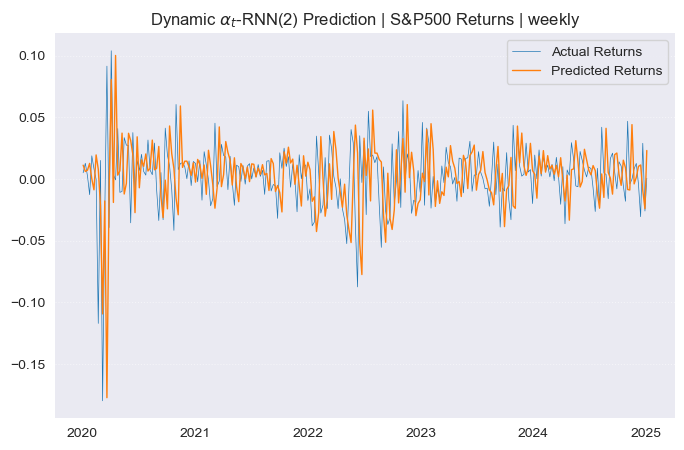

In [19]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_alpha_t_rnn, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'Dynamic $\alpha_t$-RNN(2) Prediction | S&P500 Returns | weekly')
plt.show()

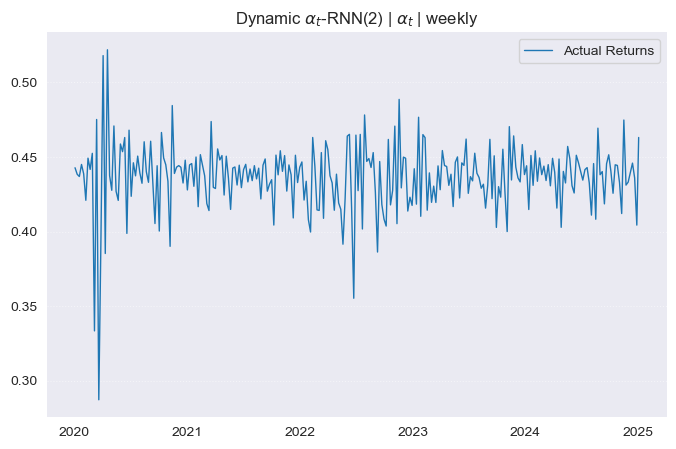

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(
    y_test.index,
    alphas[:, -1, :].mean(dim=1).squeeze().numpy(), 
    label = 'Actual Returns', 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'Dynamic $\alpha_t$-RNN(2) | $\alpha_t$ | weekly')
plt.show()

### Model Comparison

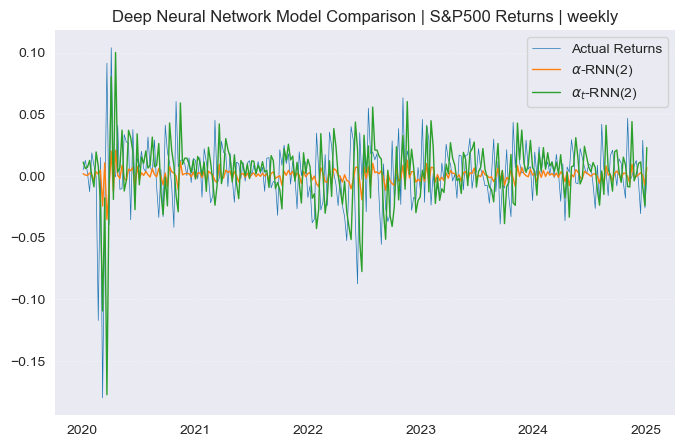

In [21]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_alpha_rnn, label = r'$\alpha$-RNN(2)', lw = 1)
plt.plot(y_test.index, predicted_alpha_t_rnn, label = r'$\alpha_t$-RNN(2)', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'Deep Neural Network Model Comparison | S&P500 Returns | weekly')
plt.show()